# Gardening Assistant

### Import all the Dependencies

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Set all the Constants

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

### Import data into tensorflow dataset object

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 7170 files belonging to 7 classes.


In [6]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Leaf_Mold',
 'Tomato_healthy']

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[6 6 5 5 3 6 6 4 5 2 0 6 2 1 5 6 5 5 2 1 1 5 0 1 2 6 6 3 1 1 5 3]


### Visualize some of the images from our dataset

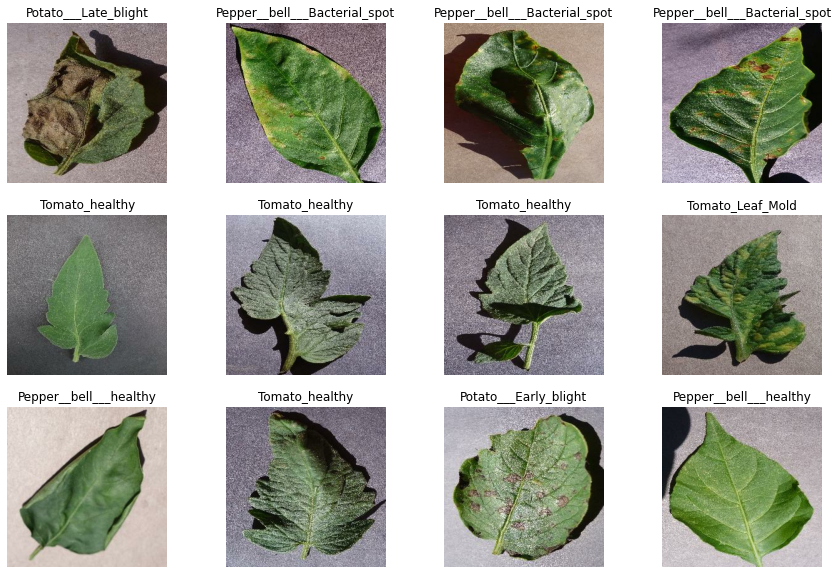

In [8]:
plt.figure(figsize=(15, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
len(dataset)

225

In [10]:
train_size = 0.8
len(dataset)*train_size

180.0

In [11]:
train_ds = dataset.take(54)
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

171

In [13]:
val_size=0.1
len(dataset)*val_size

22.5

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

165

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

180

In [19]:
len(val_ds)

22

In [20]:
len(test_ds)

23

### Cache, Shuffle, and Prefetch the Dataset

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

In [22]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

### Data Augmentation


In [23]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [24]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 7

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [29]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
180/180 [==============================] - 46s 257ms/step - loss: 0.3494 - accuracy: 0.8860 - val_loss: 0.2963 - val_accuracy: 0.9048
Epoch 2/20
180/180 [==============================] - 47s 262ms/step - loss: 0.2285 - accuracy: 0.9248 - val_loss: 0.4039 - val_accuracy: 0.8807
Epoch 3/20
180/180 [==============================] - 47s 259ms/step - loss: 0.2090 - accuracy: 0.9304 - val_loss: 0.2228 - val_accuracy: 0.9347
Epoch 4/20
180/180 [==============================] - 47s 262ms/step - loss: 0.1736 - accuracy: 0.9419 - val_loss: 0.2650 - val_accuracy: 0.9290
Epoch 5/20
180/180 [==============================] - 49s 270ms/step - loss: 0.1274 - accuracy: 0.9567 - val_loss: 0.1694 - val_accuracy: 0.9432
Epoch 6/20
180/180 [==============================] - 48s 265ms/step - loss: 0.1279 - accuracy: 0.9572 - val_loss: 0.2614 - val_accuracy: 0.9105
Epoch 7/20
180/180 [==============================] - 48s 265ms/step - loss: 0.0977 - accuracy: 0.9661 - val_loss: 0.1282 - val_ac

In [30]:
scores = model.evaluate(test_ds)

23/23 [==============================] - 8s 39ms/step - loss: 0.1792 - accuracy: 0.9429


In [32]:
scores

[0.1791764497756958, 0.9429348111152649]

### Plotting the Accuracy and Loss Curves

In [33]:
history

In [35]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 180}

In [36]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:
type(history.history['loss'])

list

In [38]:
len(history.history['loss'])

20

In [39]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.34938088059425354,
 0.22848626971244812,
 0.2089666873216629,
 0.1735653281211853,
 0.12735839188098907]

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

ValueError: x and y must have same first dimension, but have shapes (50,) and (20,)

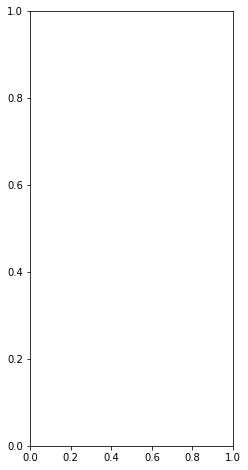

In [42]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Tomato_healthy
predicted label: Tomato_healthy


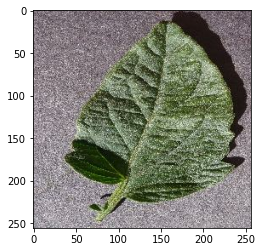

In [44]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    tf.autograph.experimental.do_not_convert
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Writing a function for inference

In [45]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now running inference on few sample images**

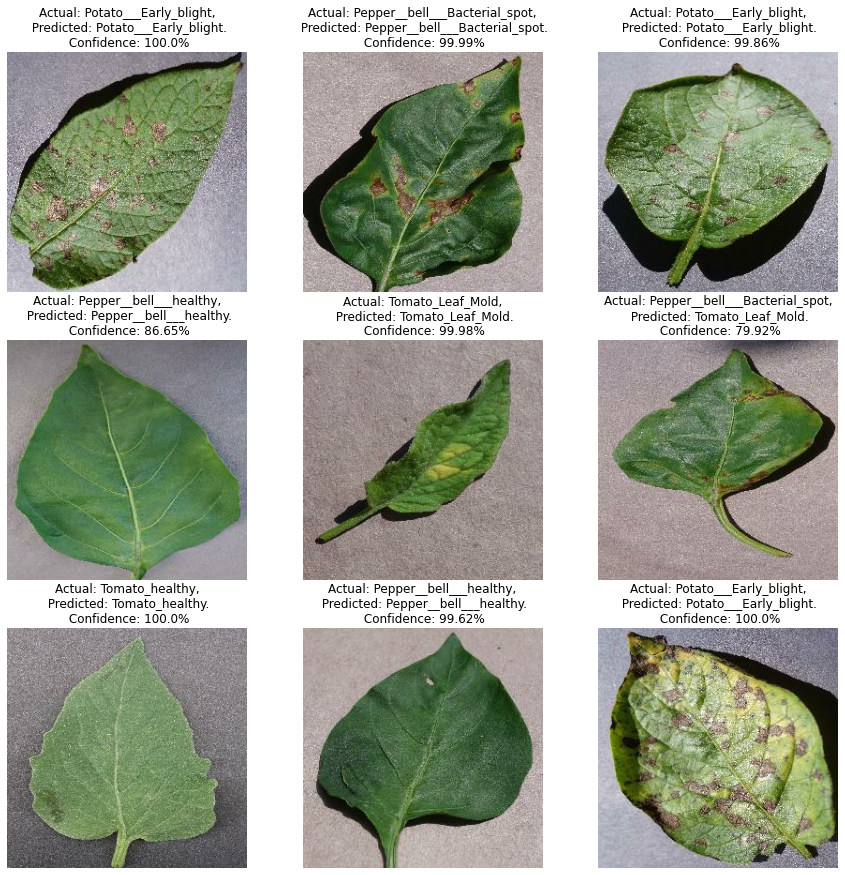

In [46]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the Model
We append the model to the list of models as a new version

In [56]:
import os
# Determine the maximum version number
#model_version = max(model_versions) + 1
model.save("models/4/model.keras")


In [110]:
import os

# Define the directory path
models_dir = r"C:\Users\Laksh\Desktop\Project\Plant Disease\training\models"

# Get the list of existing model versions
existing_versions = [int(os.path.splitext(i)[0]) for i in os.listdir(models_dir) if os.path.splitext(i)[1] == '.keras']

# Determine the next model version
model_version = max(existing_versions + [0]) + 1

# Save the model with .keras extension
model.save(os.path.join(models_dir, str(model_version) + '.keras'))


In [ ]:
loaded_model = tf.keras.models.load_model('1.keras')

In [37]:
import os

# Define the directory path
models_dir = r"C:\Users\Laksh\Desktop\Project\Plant Disease\training\models"

# Get the list of existing model versions
existing_versions = [int(i) for i in os.listdir(models_dir)] if os.path.exists(models_dir) else []

# Determine the next model version
model_version = max(existing_versions + [0]) + 1

# Save the model with .h5 extension
model.save(os.path.join(models_dir, str(model_version) + '.keras'))
